In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import re
from bs4 import BeautifulSoup
import nltk
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, accuracy_score
from scipy.sparse import hstack
from sklearn.metrics import jaccard_score
from nltk.util import ngrams
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, classification_report, multilabel_confusion_matrix
from joblib import dump, load
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Concatenate
from keras.models import Model
from keras_nlp.layers import SinePositionEncoding
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model


# Data Cleaning and Preparation

In [41]:
df_questions = pd.read_csv("Data/Questions.csv", encoding="ISO-8859-1")
df_tags = pd.read_csv("Data/Tags.csv", encoding="ISO-8859-1")

In [42]:
df_questions.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.00,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.00,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.00,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.00,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.00,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [43]:
# Dropping columns that won't be necessary for our task
df_questions.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

In [44]:
df_questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Id      1264216 non-null  int64 
 1   Score   1264216 non-null  int64 
 2   Title   1264216 non-null  object
 3   Body    1264216 non-null  object
dtypes: int64(2), object(2)
memory usage: 38.6+ MB


In [45]:
df_tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [46]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [47]:
# Grouping the tags by id
df_tags['Tag'] = df_tags['Tag'].astype(str)
grouped_tags = df_tags.groupby("Id")['Tag'].apply(lambda tag: ' '.join(tag))
grouped_tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [48]:
grouped_tags = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})
grouped_tags.head()

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


In [49]:
# Finally, mapping the tags to the questions by id
df = df_questions.merge(grouped_tags, on = "Id")
df.head()

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [50]:
# Checking the statistics of the score column to determine a good threshold to filter only high scores for better learning later on
pd.set_option('display.float_format', '{:.2f}'.format)
df['Score'].describe()

count   1264216.00
mean          1.78
std          13.66
min         -73.00
25%           0.00
50%           0.00
75%           1.00
max        5190.00
Name: Score, dtype: float64

In [51]:
# Filter based on a threshold for scores
print(f'Shape before filtering: {df.shape}')

score_threshold = 2
mask = df['Score'] >= score_threshold
df = df[mask]

print(f'Shape after filtering: {df.shape}')


Shape before filtering: (1264216, 5)
Shape after filtering: (72950, 5)


In [52]:
df.sample(5)

,Id,Score,Title,Body,Tags
114540,4697010,7,nginx: auth_basic and php,<p>i want to protect a folder of my website wi...,php authentication nginx
43617,2122820,9,Is it better to handle friendly/clean/pretty U...,<p>I'm developing my first decent-sized PHP si...,php apache mod-rewrite url-rewriting friendly-url
239842,8951810,99,how to parse json data with jquery / javascript?,<p>I have a ajax call that returns some json l...,jquery ajax json parsing
453877,15913150,37,"What is the ""proper"" way to cast Hibernate Que...","<p>I'm a newbie with Hibernate, and I'm writin...",java hibernate generics
656878,22503180,10,What is the purpose of the methods in System.R...,"<p>Since .NET 4.5 (2012), some new extension m...",c# .net reflection .net-4.5 bcl


In [53]:
# Removing columns that are no longer required and removing duplicates if any
df.drop(columns= ['Id', 'Score'], inplace=True)
df.drop_duplicates(inplace = True)

In [54]:
df.head()

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [55]:
df.shape

(72950, 3)

In [56]:
# Getting all unique tags in the data
df['Tags'] = df['Tags'].apply(lambda tag: tag.split())

# All the tags
all_tags = [item for sublist in df['Tags'].values for item in sublist]
print(f'Total tags count: {len(all_tags)}')

# Unique Tags
unique_tags = list(set(all_tags))
print(f'Unique tags count: {len(unique_tags)}')

Total tags count: 224129
Unique tags count: 14883


In [57]:
# Getting the frequency distribution of all tags
tags_frequencies = nltk.FreqDist(all_tags)
tags_frequencies

FreqDist({'c#': 6907, 'java': 6862, 'javascript': 5560, 'android': 5052, 'python': 4442, 'c++': 4369, 'php': 3024, 'jquery': 2770, '.net': 2705, 'ios': 2685, ...})

In [58]:
# Choosing top N tags
num_tags = 100
tags_most_common = tags_frequencies.most_common(num_tags)
tags_most_common = [entry[0] for entry in tags_most_common]

print(f'The top {len(tags_most_common)} tags are {tags_most_common}')

The top 100 tags are ['c#', 'java', 'javascript', 'android', 'python', 'c++', 'php', 'jquery', '.net', 'ios', 'html', 'css', 'c', 'iphone', 'objective-c', 'ruby-on-rails', 'sql', 'asp.net', 'mysql', 'ruby', 'r', 'git', 'asp.net-mvc', 'linux', 'sql-server', 'node.js', 'angularjs', 'django', 'performance', 'algorithm', 'string', 'xcode', 'arrays', 'wpf', 'eclipse', 'haskell', 'windows', 'scala', 'multithreading', 'json', 'c++11', 'regex', 'visual-studio', 'html5', 'osx', 'swift', 'database', 'unit-testing', 'spring', 'xml', 'bash', 'ajax', 'delphi', 'cocoa-touch', 'ruby-on-rails-3', 'visual-studio-2010', 'linq', 'debugging', 'generics', 'perl', 'entity-framework', 'mongodb', 'winforms', 'cocoa', 'security', 'postgresql', 'css3', 'templates', 'twitter-bootstrap', 'shell', 'list', 'google-chrome', 'vim', 'oop', 'image', 'hibernate', 'gcc', 'asp.net-mvc-3', 'facebook', 'oracle', 'rest', 'maven', 'http', 'exception', 'tsql', 'math', 'numpy', 'svn', 'qt', 'ipad', 'function', 'datetime', 'wcf'

In [59]:
# Function to filter most common tags
def filter_tags_by_most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_most_common:
            tags_filtered.append(tags[i])
    return tags_filtered

In [60]:
# Apply filter and fill empty cells with None, and finally drop the null rows
df['Tags'] = df['Tags'].apply(lambda tags: filter_tags_by_most_common(tags))
df['Tags'] = df['Tags'].apply(lambda tags: tags if len(tags)>0 else None)
df.dropna(subset=['Tags'], inplace=True)


In [61]:
df.shape

(63167, 3)

In [62]:
# Remove HTML tags from the test in the Body column
df['Body'] = df['Body'].apply(lambda body: BeautifulSoup(body).get_text())

In [63]:
df.head()

,Title,Body,Tags
1,Good branching and merging tutorials for Torto...,Are there any really good tutorials explaining...,[svn]
2,ASP.NET Site Maps,Has anyone got experience creating SQL-based A...,"[sql, asp.net]"
3,Function for creating color wheels,This is something I've pseudo-solved many time...,[algorithm]
4,Adding scripting functionality to .NET applica...,I have a little game written in C#. It uses a ...,"[c#, .net]"
5,Should I use nested classes in this case?,I am working on a collection of classes used f...,"[c++, oop, class]"


In [64]:
# Save the cleaned data
df.to_csv('Output/TaggedQuestions.csv')

# Preprocessing

In [65]:
# Takes a list of tokens, and lemmatizes them. Optionally, POS tagging can be enabled
def lemmatize_tokens(tokens, use_POS: bool = False):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    
    if use_POS:
        # Tag the tokens using POS and lemmatize accordingly
        tagged_tokens = pos_tag(tokens)
        for token, pos in tagged_tokens:
            if pos.startswith('NN'):  # Noun
                lemmatized_token = lemmatizer.lemmatize(token, pos='n')
            elif pos.startswith('VB'):  # Verb
                lemmatized_token = lemmatizer.lemmatize(token, pos='v')
            elif pos.startswith('JJ'):  # Adjective
                lemmatized_token = lemmatizer.lemmatize(token, pos='a')
            elif pos.startswith('RB'):  # Adverb
                lemmatized_token = lemmatizer.lemmatize(token, pos='r')
            else: # Default lemmatization
                lemmatized_token = lemmatizer.lemmatize(token)
                
            lemmatized_tokens.append(lemmatized_token)
    else:
        # Lemmatize without POS tagging
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens

In [66]:
# Performs an NLP pipeline on text input, it removes punctuation and stopwords, tokenizes the text, then lemmatizes it with options for POS tagging and using n_grams
def preprocess_text(text, num_grams=1, use_POS = False):
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Tokenize text and transform to lower cass
        tokens = word_tokenize(text.lower())
        
        # Prepare stop words
        stop_words = set(stopwords.words('english'))
        
        # Remove stop words
        filtered_tokens = [token for token in tokens if token not in stop_words]

        # Lemmatize/stem
        lemmatized_tokens = lemmatize_tokens(filtered_tokens, use_POS= use_POS)

        # Generate n-grams
        if num_grams > 1:
            n_grams = list(ngrams(lemmatized_tokens, num_grams))
            # Rejoin n-grams into a string (each n-gram is joined by a space and then all n-grams are joined into one string)
            return ' '.join([' '.join(gram) for gram in n_grams])
        else:
            # Rejoin tokens into a string for unigrams
            return ' '.join(lemmatized_tokens)

In [67]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MenaA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MenaA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [68]:
# Preprocess the Title and Body of the questions using the NLP pipeline defined above
df['Body'] = df['Body'].apply(lambda text: preprocess_text(text, num_grams= 1, use_POS= True))
df['Title'] = df['Title'].apply(lambda text: preprocess_text(text, num_grams= 1, use_POS= True))

In [69]:
df.sample(5)

,Title,Body,Tags
269756,leave unreachable break case throw exception,silly leave unreachable break statement case t...,"[c#, exception]"
214815,access model attribute scriptlet,using spring mvc controller setting standard m...,[html]
26239,python automatically initialize instance variable,python class look like class process def inits...,"[python, class]"
248464,gem install pg withpgconfig work bundle fails,wheni run root gem install pg v 0120 withpgcon...,[postgresql]
582506,removing index column panda,following code import csv file 3 column want s...,[python]


In [70]:
df.to_csv('Output/Preprocessed.csv')

In [2]:
import ast

# Load the CSV
df = pd.read_csv('Output/TaggedQuestions.csv')

# Ensure Title and Body columns are strings
df['Title'] = df['Title'].astype(str)
df['Body'] = df['Body'].astype(str)

# Convert the Tags column from string representation of list to actual list
df['Tags'] = df['Tags'].apply(ast.literal_eval)

In [3]:
# Make sure tags are viewed as lists of strings
df['Tags'].head()

0          [sql, asp.net]
1             [algorithm]
2              [c#, .net]
3              [c++, oop]
4    [.net, web-services]
Name: Tags, dtype: object

In [4]:
# Extracting features and target variable
X = df[['Title', 'Body']]
y = df['Tags']

In [5]:
X.shape

(264636, 2)

# Splitting the data

In [6]:
# Train/test split, test has 10000 samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 10000, random_state = 42)

# Further splitting the training set into train/dev sets with 10000 samples in dev
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size = 10000, random_state = 42)

In [7]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_dev: {X_dev.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X_train: (244636, 2)
Shape of X_dev: (10000, 2)
Shape of X_test: (10000, 2)


# Feature Representation

In [8]:
# Function that puts labels of tags in a binary format
def binarize_labels(labels,  is_test=False):
    if is_test:
        # Load the binarizer used during training and transform labels using it
        multilabel_binarizer : MultiLabelBinarizer = load("Output/multilabel_binarizer.joblib")
        labels = multilabel_binarizer.transform(labels)
    else:
        # Tokenization
        multilabel_binarizer = MultiLabelBinarizer()
        labels = multilabel_binarizer.fit_transform(labels)
        dump(multilabel_binarizer, "Output/multilabel_binarizer.joblib")

    return labels


In [9]:

print(f'y_train shape before binarization: {y_train.shape}')
print(f'y_train sample before binarization: {y_train.iloc[0]}')


y_train shape before binarization: (244636,)
y_train sample before binarization: ['java']


In [10]:
# Binarizing
y_train = binarize_labels(y_train)
y_dev = binarize_labels(y_dev, is_test=True)
y_test = binarize_labels(y_test, is_test=True)

In [11]:
print(f'y_train shape after binarization: {y_train.shape}')
print(f'y_dev shape after binarization: {y_dev.shape}')
print(f'y_test shape after binarization: {y_test.shape}')
print(f'y_train sample after binarization: {y_train[0]}')

y_train shape after binarization: (244636, 100)
y_dev shape after binarization: (10000, 100)
y_test shape after binarization: (10000, 100)
y_train sample after binarization: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [12]:
# Tokenizes text, encodes it and then pads it all to a similar length to prepare for the embedding layer.
def prepare_for_embedding(texts, feature_name, max_length=None, is_test=False):
    if is_test:
        # Load the tokenizer used during training
        tokenizer = load(f"Output/tokenizer_{feature_name}.joblib")
    else:
        # Tokenization
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(texts)
        # Save the tokenizer for later use during testing
        dump(tokenizer, f"Output/tokenizer_{feature_name}.joblib")

    # Integer Encoding
    sequences = tokenizer.texts_to_sequences(texts)

    # Vocabulary size (+1 for padding token)
    vocab_size = len(tokenizer.word_index) + 1

    # Padding Sequences
    if max_length is None:
        max_length = max(len(sequence) for sequence in sequences)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

    return padded_sequences, vocab_size

In [13]:
# Prepare the title for embedding layer
X_train_title_embedded, vocab_size_title = prepare_for_embedding(X_train['Title'], 'title')
X_dev_title_embedded, _ = prepare_for_embedding(X_dev['Title'], 'title', max_length= X_train_title_embedded.shape[1], is_test= True)
X_test_title_embedded, _ = prepare_for_embedding(X_test['Title'], 'title', max_length= X_train_title_embedded.shape[1], is_test= True)

In [14]:
# Checking the shapes and vocab size
print(f'X_train shape: {X_train_title_embedded.shape}')
print(f'X_dev shape: {X_dev_title_embedded.shape}')
print(f'X_test shape: {X_test_title_embedded.shape}')
print(f'vocabulary size is: {vocab_size_title}')

# Checking some sample to understand exactly what is happening
print(X_train_title_embedded[0])

# Every token gets assigned an integer mapping, and then all tokens are mapped, and finally padded with zeroes to unify length to that of max sequence length

X_train shape: (244636, 33)
X_dev shape: (10000, 33)
X_test shape: (10000, 33)
vocabulary size is: 53889
[  29   22   15   24   91 1429   12 1863  254   60    9  312    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]


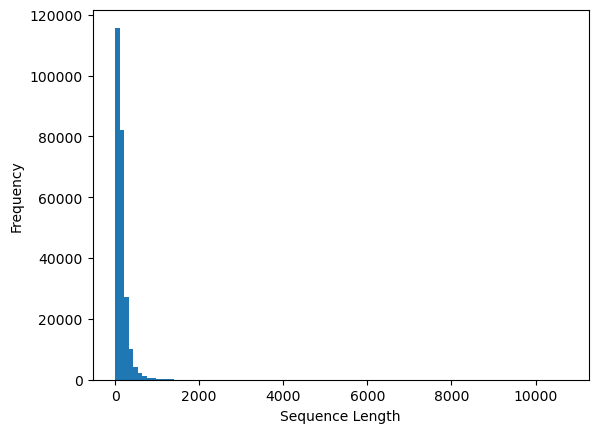

Max sequence length is: 10725
Average sequence length is: 151.80631223532106
90th precentile: 292.0


In [15]:
# Checking body length distribution to determine optimal sequence length for performance and efficiency

sequence_lengths = [len(body.split()) for body in X_train['Body'].values]
plt.hist(sequence_lengths, bins=100)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

print(f'Max sequence length is: {max(sequence_lengths)}')
print(f'Average sequence length is: {np.mean(sequence_lengths)}')
print(f'90th precentile: {np.percentile(sequence_lengths, 90)}') 

In [16]:
# Clearly some outlier or rare sentences have very long length, but we will choose a lower one that well suits at least 90% of the training data
max_sequence_length = 300

In [17]:
# Prepare the body for embedding layer
X_train_body_embedded, vocab_size_body = prepare_for_embedding(X_train['Body'], 'body', max_length= max_sequence_length)
X_dev_body_embedded, _ = prepare_for_embedding(X_dev['Body'], 'body', max_length= X_train_body_embedded.shape[1], is_test= True)
X_test_body_embedded, _ = prepare_for_embedding(X_test['Body'], 'body' ,max_length= X_train_body_embedded.shape[1], is_test= True)

In [18]:
# Checking the shapes and vocab size
print(f'X_train shape: {X_train_body_embedded.shape}')
print(f'X_dev shape: {X_dev_body_embedded.shape}')
print(f'X_test shape: {X_test_body_embedded.shape}')
print(f'vocabulary size is: {vocab_size_body}')

# Checking a sample
print(X_train_body_embedded[0])

X_train shape: (244636, 300)
X_dev shape: (10000, 300)
X_test shape: (10000, 300)
vocabulary size is: 784197
[  5863    421     25  31357    555    249    159    606    606     96
     48  31357    606    606    591  31357      8    606    606     48
     87    130    195   3540   9735     96   6414     92     27   6414
   9735    606   6247     95   2680      6     27   2680     27   4231
    606   4509     37  13126  84371    515      1    998    138 269393
     92      6  29474     92    421      6    421    606    421    443
    230     83     83   1388     48     87 269393   6414     92   2680
      6    867    230     37  13126     96     37    169     96    223
      1    998    225  13126      6   2170     96     34      1    169
     15  13126   5699   1881   3371    169    169  13126   2209   1881
   3371    169    252   2802    380     15  13126   1152    563    173
     98      4    169      3   1453     15    169     96    944     27
    230     99   1881   3371    169    

# Model training and evaluation

In [19]:
# Transformer block
def transformer_block(inputs, num_heads, key_dim, ff_dim, dropout_rate=0.2):
    # Multi-head Self Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)
    
    # Feed Forward Network
    ffn_output = Dense(ff_dim, activation='relu')(attention_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output + attention_output)
    
    return ffn_output

In [20]:
# Model Parameters
embedding_dim = 96   # Embedding dimension size
num_heads = 4        # Number of attention heads
key_dim = 32         # Dimensionality of each attention head for query and key
ff_dim = 128         # Hidden layer size in feed forward network
dropout_rate = 0.2   # Dropout rate

# Embedding input for the title
title_input = Input(shape=(X_train_title_embedded.shape[1],), name='title_input')
title_embedding = Embedding(input_dim=vocab_size_title, output_dim=embedding_dim)(title_input)

# Add Positional Encoding for the title
positional_encoding_title = SinePositionEncoding()(title_embedding)
title_embedding = title_embedding + positional_encoding_title

# Add Transformer block to the title input
title_transformer = transformer_block(title_embedding, num_heads, key_dim, ff_dim, dropout_rate)
title_pooling = GlobalAveragePooling1D()(title_transformer)

# Embedding input for the body
body_input = Input(shape=(X_train_body_embedded.shape[1],), name='body_input')
body_embedding = Embedding(input_dim=vocab_size_body, output_dim=embedding_dim)(body_input)

# Add Positional Encoding for the body
positional_encoding_body = SinePositionEncoding()(body_embedding)
body_embedding = body_embedding + positional_encoding_body

# Add Transformer block to the body input
body_transformer = transformer_block(body_embedding, num_heads, key_dim, ff_dim, dropout_rate)
body_pooling = GlobalAveragePooling1D()(body_transformer)

# Concatenation layer
combined = Concatenate()([title_pooling, body_pooling])

# Fully connected layers
fc_1 = Dense(128, activation='relu')(combined)
fc_1 = Dropout(dropout_rate)(fc_1)
fc_2 = Dense(64, activation='relu')(fc_1)
fc_2 = Dropout(dropout_rate)(fc_2)

# Output layer
output = Dense(y_train.shape[1], activation='sigmoid', name='output')(fc_2)

# Model definition
model = Model(inputs=[title_input, body_input], outputs=[output])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_input (InputLayer)       [(None, 33)]         0           []                               
                                                                                                  
 body_input (InputLayer)        [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 33, 96)       5173344     ['title_input[0][0]']            
                                                                                                  
 embedding_1 (Embedding)        (None, 300, 96)      75282912    ['body_input[0][0]']             
                                                                                              

In [22]:
# Define the checkpoint to save the model with the best validation accuracy
checkpoint = ModelCheckpoint(
    'Output/best_model.h5',   
    monitor='val_accuracy',
    verbose=1,         
    save_best_only=True,
    mode='max'          
)

In [23]:
# Define early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3,         
    verbose=1,          
    restore_best_weights=True
)

In [24]:
# Train the model
history = model.fit(
    [X_train_title_embedded, X_train_body_embedded], y_train,
    validation_data=([X_dev_title_embedded, X_dev_body_embedded], y_dev),
    epochs=20,
    batch_size=256,
    callbacks=[checkpoint, early_stopping] 
)

Epoch 1/20
956/956 [==============================] - ETA: 0s - loss: 0.0858 - accuracy: 0.1022
Epoch 1: val_accuracy improved from -inf to 0.30160, saving model to Output\best_model.h5
956/956 [==============================] - 129s 132ms/step - loss: 0.0858 - accuracy: 0.1022 - val_loss: 0.0577 - val_accuracy: 0.3016
Epoch 2/20
956/956 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.4670
Epoch 2: val_accuracy improved from 0.30160 to 0.56890, saving model to Output\best_model.h5
956/956 [==============================] - 136s 143ms/step - loss: 0.0450 - accuracy: 0.4670 - val_loss: 0.0342 - val_accuracy: 0.5689
Epoch 3/20
956/956 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.5782
Epoch 3: val_accuracy improved from 0.56890 to 0.60540, saving model to Output\best_model.h5
956/956 [==============================] - 126s 132ms/step - loss: 0.0335 - accuracy: 0.5782 - val_loss: 0.0298 - val_accuracy: 0.6054
Epoch 4/20
956/956 [===========

In [25]:
# Visualize the learning curves (Loss and Accuracy)
def plot_learning_curves(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.show()

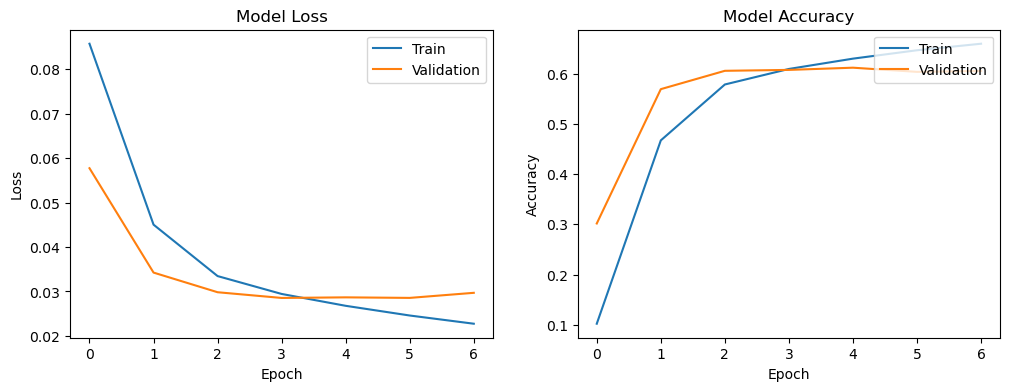

In [26]:
# Call the function to plot the learning curves
plot_learning_curves(history)

# Model Evaluation on unseen data

In [29]:
# Load the best model (with the best weights)
best_model = load_model('Output/best_model.h5')

In [33]:
# Evaluate the model on the test set for accuracy and loss
loss, accuracy = best_model.evaluate([X_test_title_embedded, X_test_body_embedded], y_test)
print(f"Accuracy on unseen test set: {accuracy * 100:.2f}%")
print(f"Loss on unseen test set: {loss:.4f}")

313/313 [==============================] - 4s 11ms/step - loss: 0.0280 - accuracy: 0.6148
Accuracy on unseen test set: 61.48%
Loss on unseen test set: 0.0280


In [46]:
# Predict on the test set
y_pred = best_model.predict([X_test_title_embedded, X_test_body_embedded])

# Threshold the predictions to get binary results
y_pred = (y_pred > 0.5).astype(int)

# Post-processing predictions to ensure at least one label is predicted per sample
for i in range(y_pred.shape[0]):
    if y_pred[i].sum() == 0:
        # Set the label with the highest probability as 1 if no label is predicted
        y_pred[i, np.argmax(y_pred[i])] = 1

313/313 [==============================] - 3s 9ms/step


In [47]:
# Precision, Recall, and F1 Score
precision = precision_score(y_test, y_pred, average='samples')
recall = recall_score(y_test, y_pred, average='samples')
f1 = f1_score(y_test, y_pred, average='samples')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.7675
Recall: 0.6741
F1 Score: 0.6881


In [48]:
# Jaccard Score can be useful in evaluating multi label classification models, because it measures the similarity between predictions and actual values. 
# It takes into consideration how close the model got to predict most of the tags, rather than just evaluating whether it got them all right or not (which is what the accuracy score does)
jaccard = jaccard_score(y_test, y_pred, average='samples')
print(f"Jaccard Score: {jaccard * 100:.2f}%")

Jaccard Score: 62.40%


### The model seems to perform reasonably well considering that there is 100 tags for it to differentiate among, and also considering the human baseline error for this specific task.